   dmsp_total_light area_type  nightlight_area_interaction
0                 0     RURAL                            0
1                 0     RURAL                            0
2                 0     RURAL                            0
3                 0     RURAL                            0
4                 0     RURAL                            0


/var/folders/wm/lp427bhn21l7_b9826wl131h0000gn/T/ipykernel_8235/1987550584.py:42: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["nightlight_area_interaction"].fillna(0, inplace=True)


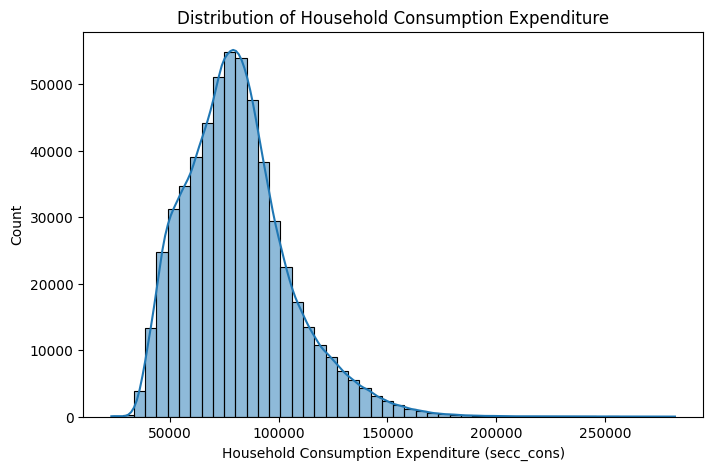

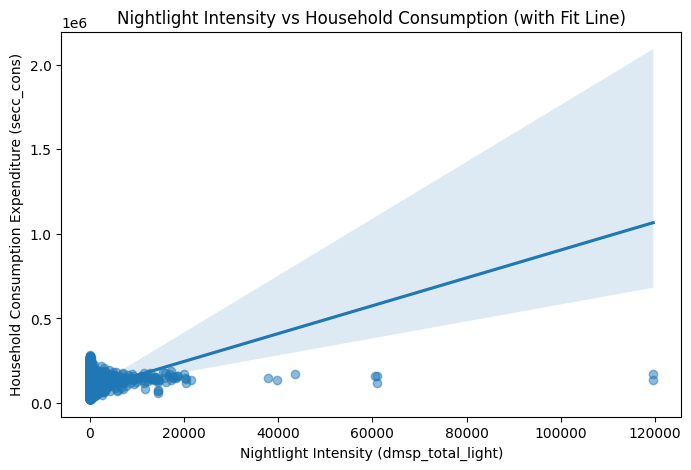

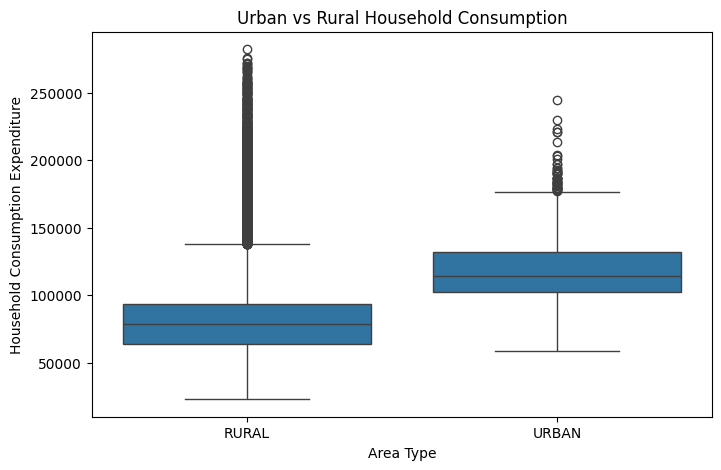

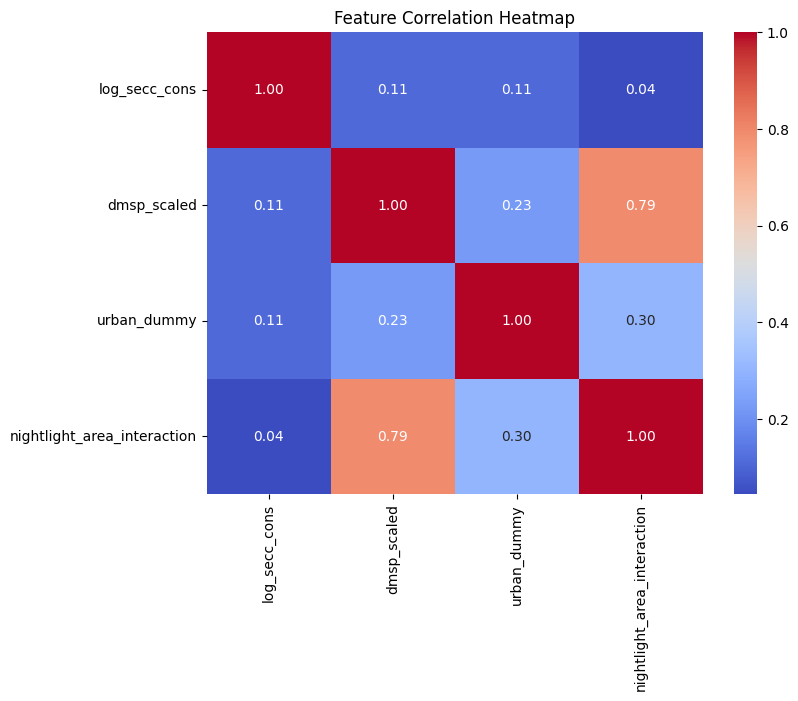

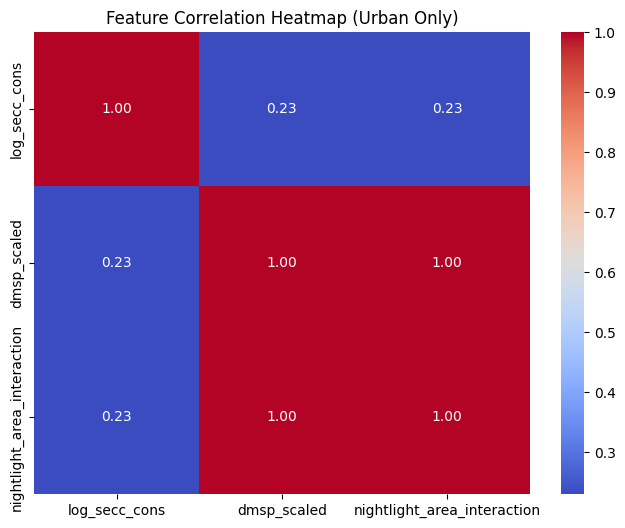

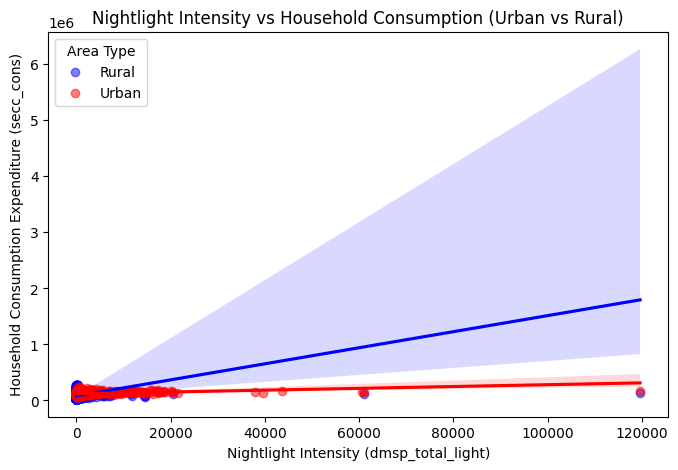

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import os

# Define file paths
data_path = "/Users/bishmaybarik/Library/CloudStorage/OneDrive-ShivNadarInstitutionofEminence/nightlight_atlas/01_data/02_processed/secc_combined_updated.csv"
save_path = "/Users/bishmaybarik/Library/CloudStorage/OneDrive-ShivNadarInstitutionofEminence/nightlight_atlas/05_reports/data"

# Ensure save path exists
os.makedirs(save_path, exist_ok=True)

# Load dataset
df = pd.read_csv(data_path)

# Standardize area_type column
df["area_type"] = df["area_type"].str.strip().str.upper()  # Convert to uppercase ("URBAN" & "RURAL")

# Apply log transformation to secc_cons
df["log_secc_cons"] = np.log1p(df["secc_cons"])

# Create interaction term: Nightlight Intensity × Urban Dummy
df["nightlight_area_interaction"] = df["dmsp_total_light"] * (df["area_type"] == "URBAN").astype(int)

# Scaling Nightlight Intensity
scaler = StandardScaler()
df["dmsp_scaled"] = scaler.fit_transform(df[["dmsp_total_light"]])

# One-hot encoding for area_type
encoder = OneHotEncoder(sparse_output=False, drop="first")  # Drop first to avoid multicollinearity
df["urban_dummy"] = encoder.fit_transform(df[["area_type"]])[:, 0]  # Convert NumPy array to Series

# Verify interaction term
print(df[["dmsp_total_light", "area_type", "nightlight_area_interaction"]].head())

# Ensure interaction term is numeric
df["nightlight_area_interaction"] = df["nightlight_area_interaction"].astype(float)

# Check for NaN values and replace if necessary
df["nightlight_area_interaction"].fillna(0, inplace=True)

# ----- PLOTTING & SAVING GRAPHS -----

# Histogram of household consumption
plt.figure(figsize=(8, 5))
sns.histplot(df["secc_cons"], bins=50, kde=True)
plt.xlabel("Household Consumption Expenditure (secc_cons)")
plt.ylabel("Count")
plt.title("Distribution of Household Consumption Expenditure")
plt.savefig(os.path.join(save_path, "hist_secc_cons.png"))
plt.show()

# Scatter plot: Nightlight Intensity vs Household Consumption (with regression line)
plt.figure(figsize=(8, 5))
sns.regplot(x=df["dmsp_total_light"], y=df["secc_cons"], scatter_kws={'alpha':0.5})
plt.xlabel("Nightlight Intensity (dmsp_total_light)")
plt.ylabel("Household Consumption Expenditure (secc_cons)")
plt.title("Nightlight Intensity vs Household Consumption (with Fit Line)")
plt.savefig(os.path.join(save_path, "scatter_nightlight_vs_secc.png"))
plt.show()

# Boxplot: Urban vs. Rural Consumption
plt.figure(figsize=(8, 5))
sns.boxplot(x=df["area_type"], y=df["secc_cons"])
plt.xlabel("Area Type")
plt.ylabel("Household Consumption Expenditure")
plt.title("Urban vs Rural Household Consumption")
plt.savefig(os.path.join(save_path, "boxplot_urban_rural.png"))
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df[["log_secc_cons", "dmsp_scaled", "urban_dummy", "nightlight_area_interaction"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.savefig(os.path.join(save_path, "correlation_heatmap.png"))
plt.show()

# ----- OPTIONAL: SEPARATE ANALYSIS FOR URBAN & RURAL -----

# Subset Urban Data
df_urban = df[df["area_type"] == "URBAN"]

if not df_urban.empty:  # Only plot if urban data exists
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_urban[["log_secc_cons", "dmsp_scaled", "nightlight_area_interaction"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Feature Correlation Heatmap (Urban Only)")
    plt.savefig(os.path.join(save_path, "correlation_heatmap_urban.png"))
    plt.show()

# Scatter plot: Nightlight Intensity vs Household Consumption (Urban & Rural Segregated)
plt.figure(figsize=(8, 5))

# Plot Rural households
sns.regplot(data=df[df["area_type"] == "RURAL"], 
            x="dmsp_total_light", 
            y="secc_cons", 
            scatter_kws={'alpha': 0.5, 'color': 'blue'}, 
            line_kws={'color': 'blue'}, 
            label="Rural")

# Plot Urban households
sns.regplot(data=df[df["area_type"] == "URBAN"], 
            x="dmsp_total_light", 
            y="secc_cons", 
            scatter_kws={'alpha': 0.5, 'color': 'red'}, 
            line_kws={'color': 'red'}, 
            label="Urban")

# Labels and title
plt.xlabel("Nightlight Intensity (dmsp_total_light)")
plt.ylabel("Household Consumption Expenditure (secc_cons)")
plt.title("Nightlight Intensity vs Household Consumption (Urban vs Rural)")
plt.legend(title="Area Type")
plt.savefig(os.path.join(save_path, "scatter_nightlight_vs_secc_urban_rural.png"))
plt.show()


In [18]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Define features and target variable
features = ["dmsp_scaled", "urban_dummy", "nightlight_area_interaction"]
target = "log_secc_cons"  # Predicting log-transformed secc_cons

# Convert to NumPy arrays
X = df[features].values
y = df[target].values

# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print dataset shapes
print(f"Training Set: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Testing Set: X_test: {X_test.shape}, y_test: {y_test.shape}")


Training Set: X_train: (453943, 3), y_train: (453943,)
Testing Set: X_test: (113486, 3), y_test: (113486,)


In [19]:
# Define the neural network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation="relu", input_shape=(3,)),  # First hidden layer
    tf.keras.layers.Dense(32, activation="relu"),  # Second hidden layer
    tf.keras.layers.Dense(1)  # Output layer (predicting log_secc_cons)
])

# Compile the model
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)


Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7093/7093 ━━━━━━━━━━━━━━━━━━━━ 3s 349us/step - loss: 42.8200 - mae: 1.3796 - val_loss: 0.5227 - val_mae: 0.2724
Epoch 2/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 341us/step - loss: 6.2665 - mae: 0.2974 - val_loss: 1.0528 - val_mae: 0.2393
Epoch 3/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 337us/step - loss: 2.8850 - mae: 0.2615 - val_loss: 0.2546 - val_mae: 0.2491
Epoch 4/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 344us/step - loss: 0.3208 - mae: 0.2434 - val_loss: 0.2834 - val_mae: 0.2526
Epoch 5/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 333us/step - loss: 0.3527 - mae: 0.2526 - val_loss: 0.1095 - val_mae: 0.2299
Epoch 6/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 335us/step - loss: 0.1788 - mae: 0.2390 - val_loss: 0.1391 - val_mae: 0.2362
Epoch 7/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 333us/step - loss: 0.1166 - mae: 0.2333 - val_loss: 0.1071 - val_mae: 0.2319
Epoch 8/50
7093/7093 ━━━━━━━━━━━━━━━━━━━━ 2s 333us/step - loss: 0.3356 - mae: 0.2326 - val_loss: 0.1148 - val_mae: 0.2316
Epoch 9/50
7093/7093 ━━━━━━━━━━━━━

3547/3547 ━━━━━━━━━━━━━━━━━━━━ 1s 201us/step - loss: 0.0762 - mae: 0.2202
Test Loss (MSE): 0.0757
Test MAE: 0.2193


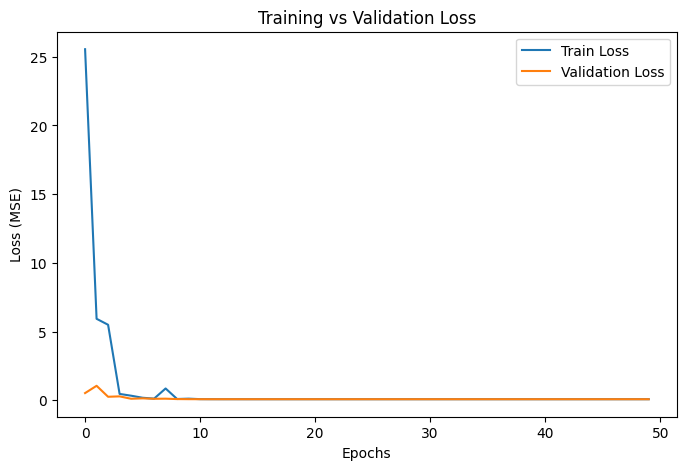

3547/3547 ━━━━━━━━━━━━━━━━━━━━ 1s 205us/step


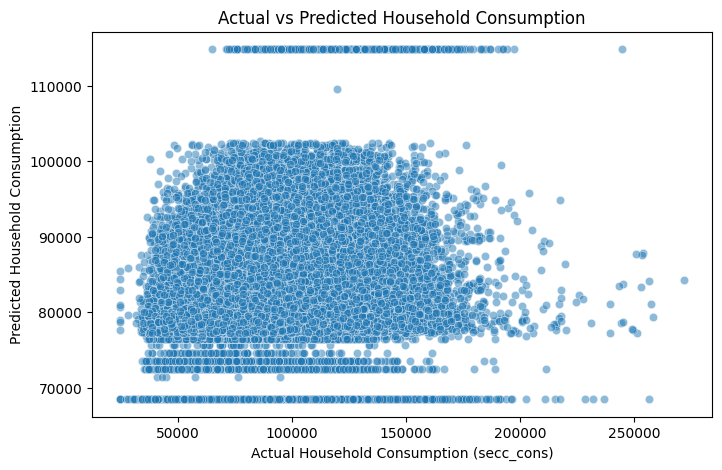

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os

# Define save path
save_path = "/Users/bishmaybarik/Library/CloudStorage/OneDrive-ShivNadarInstitutionofEminence/nightlight_atlas/05_reports/model_results"
os.makedirs(save_path, exist_ok=True)

# Evaluate model on test data
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss (MSE): {test_loss:.4f}")
print(f"Test MAE: {test_mae:.4f}")

# Plot training history
plt.figure(figsize=(8, 5))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title("Training vs Validation Loss")
plt.legend()
plt.savefig(os.path.join(save_path, "training_vs_validation_loss.png"))  # Save figure
plt.show()

# Make predictions
y_pred_log = model.predict(X_test)

# Convert log predictions back to original scale
y_pred = np.expm1(y_pred_log)

# Convert actual log values back to original scale
y_test_actual = np.expm1(y_test)

# Scatter plot of predicted vs actual values
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_test_actual, y=y_pred.flatten(), alpha=0.5)
plt.xlabel("Actual Household Consumption (secc_cons)")
plt.ylabel("Predicted Household Consumption")
plt.title("Actual vs Predicted Household Consumption")
plt.savefig(os.path.join(save_path, "actual_vs_predicted_consumption.png"))  # Save figure
plt.show()

In [21]:
pip install shap


[notice] A new release of pip is available: 24.1.1 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [23]:
import shap  # Import SHAP
explainer = shap.Explainer(model, X_train)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
# Compute SHAP values
shap_values = explainer(X_test)


ExactExplainer explainer: 113487it [03:16, 551.20it/s]                            


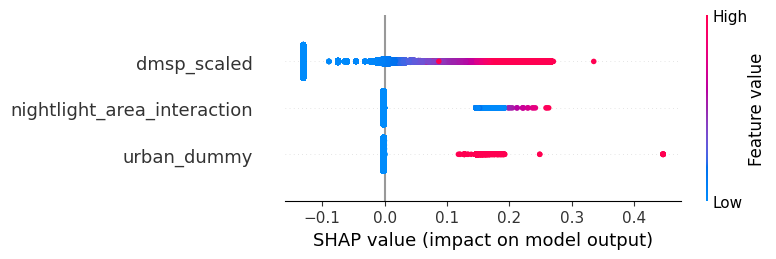

In [25]:
# SHAP summary plot
shap.summary_plot(shap_values, X_test, feature_names=features)


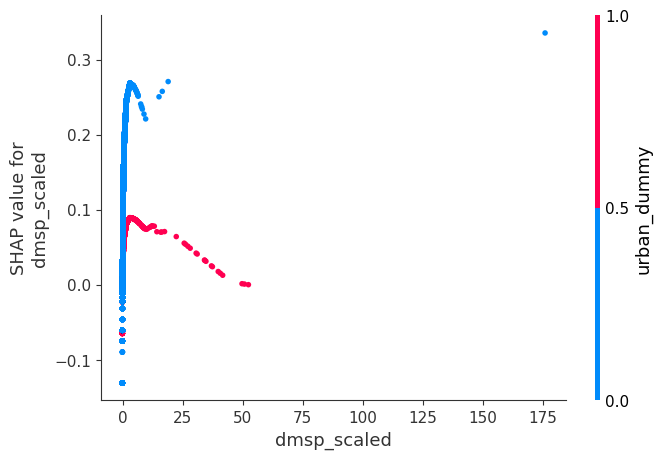

In [26]:
# SHAP dependence plot for Nightlight Intensity
shap.dependence_plot(0, shap_values.values, X_test, feature_names=features)

14186/14186 ━━━━━━━━━━━━━━━━━━━━ 3s 207us/step


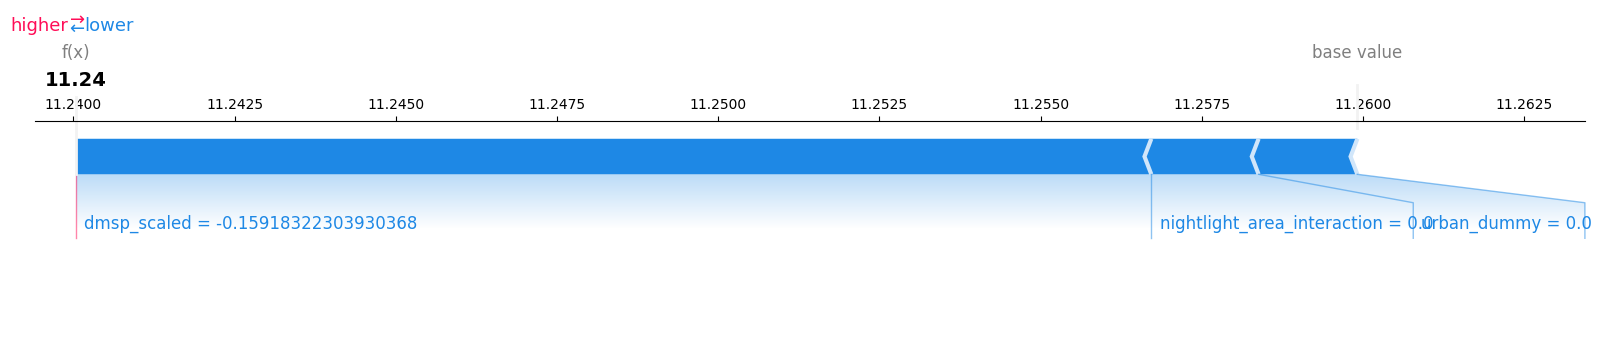

In [27]:
# Compute the base value (mean prediction of training set)
base_value = model.predict(X_train).mean()

# Pick a random test instance
random_index = np.random.randint(0, X_test.shape[0])

# Generate force plot
shap.force_plot(
    base_value, 
    shap_values[random_index].values, 
    X_test[random_index], 
    feature_names=features, 
    matplotlib=True
)


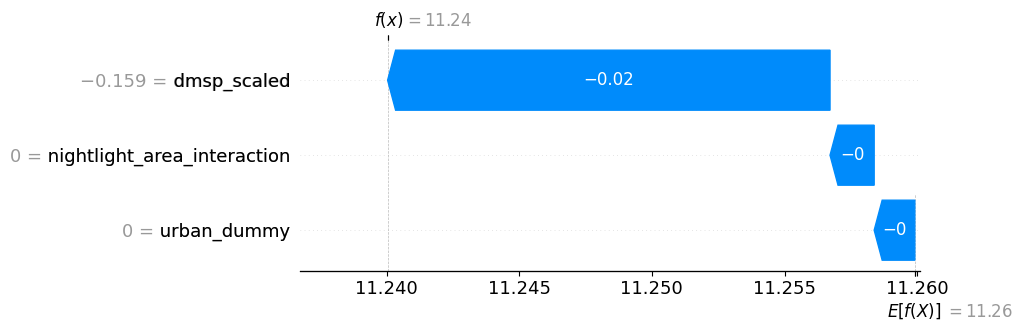

In [28]:
# Generate waterfall plot for a single prediction
shap.waterfall_plot(
    shap.Explanation(
        values=shap_values[random_index].values, 
        base_values=base_value,  # Use computed base value
        data=X_test[random_index], 
        feature_names=features
    )
)
